# SBB Train Delay Analysis with Dask

In this project, we analyze real operational delay data from SBB (Swiss Federal Railways) for May 2025. Our goal is to evaluate the performance of long-distance train lines (IC, IR, EC, ICE) using the Dask framework for scalable, parallel data processing.

We focus on answering:
- Which train lines experience the most delays?
- At what time of day or days of the week are delays more common?
- Evaluate Dask's suitability for processing large-scale public transport data.

The project also aims to reflect on the efficiency and usability of Dask in comparison with PySpark.


In [3]:
!pip install -r requirements.txt
from dask.distributed import Client
client = Client(processes=True, n_workers=8, threads_per_worker=2, memory_limit='4GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55200,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:55251,Total threads: 2
Dashboard: http://127.0.0.1:55258/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:55203,


## Step 1: Load and Prepare SBB Delay Data

We load official SBB delay records from the May 2025 archive. The dataset contains millions of records in CSV format, which we parse into a Dask DataFrame with the correct data types and timestamp parsing. This approach allows scalable handling of large data volumes without overloading memory.


In [7]:
import requests
import os
import glob
import dask.dataframe as dd
import pandas as pd
import zipfile
import time
from datetime import datetime

# ---------- Define Column Type Fixes ----------
dtype_overrides = {
    "LINIEN_ID": "str",
    "LINIEN_TEXT": "str",
    "UMLAUF_ID": "str"
}

# ---------- Define Date Parsers ----------

# Download and extract the ZIP file
url = "https://archive.opentransportdata.swiss/istdaten/2025/ist-daten-2025-05.zip"
local_zip = "data/sbb/ist-daten-2025-05.zip"
extract_dir = "data/sbb/2025-05"

os.makedirs(extract_dir, exist_ok=True)

# Download
if not os.path.exists(local_zip):
    print("Downloading archive...")
    r = requests.get(url)
    r.raise_for_status()
    with open(local_zip, "wb") as f:
        f.write(r.content)
    print("Downloaded:", local_zip)

# Extract
with zipfile.ZipFile(local_zip, "r") as z:
    z.extractall(extract_dir)
    print("Extracted to:", extract_dir)

# Load all CSVs into a Dask DataFrame
start = time.time() # for measurments
csv_files = glob.glob(os.path.join(extract_dir, "*_istdaten.csv"))
ddf = dd.read_csv(
    csv_files,
    sep=";",
    dtype=dtype_overrides,
    assume_missing=True
)

csv_read_duration = time.time() - start
print(f"✅ Dask read_csv complete in {round(time.time() - start, 2)}s")


print("Dask read_csv complete")


date_fmt = "%d.%m.%Y"
datetime_fmt = "%d.%m.%Y %H:%M"
ddf["BETRIEBSTAG"] = dd.to_datetime(ddf["BETRIEBSTAG"], format=date_fmt, errors="coerce")
ddf["ANKUNFTSZEIT"] = dd.to_datetime(ddf["ANKUNFTSZEIT"], format=datetime_fmt, errors="coerce")
ddf["ABFAHRTSZEIT"] = dd.to_datetime(ddf["ABFAHRTSZEIT"], format=datetime_fmt, errors="coerce")

print("Loaded month of SBB data")
print("Files loaded:", len(csv_files))
print("Columns:", list(ddf.columns))


Downloaded: data/sbb/ist-daten-2025-05.zip


KeyboardInterrupt: 


## Step 2: Filter Long-Distance Train Services

To narrow the scope, we filter for:
- Operator: `SBB`
- Product lines: `IC`, `IR`, `EC`, `ICE`

This ensures that our analysis focuses only on the major interregional and international routes relevant to travelers and operational planning.


In [3]:
# Measurement: Start time
t_start = time.time()

# Filter long-distance SBB trains
ddf_filtered = ddf[
    (ddf["BETREIBER_ABK"] == "SBB") &
    (ddf["VERKEHRSMITTEL_TEXT"].isin(["IR", "IC", "ICE", "EC"]))
]

# Measurement: Number of rows before setting index
n_filtered = ddf_filtered.shape[0].compute()

# Set index and persist
ddf_filtered = ddf_filtered.set_index("LINIEN_TEXT", sorted=True).persist()

# Count by LINIEN_TEXT
linien_counts = ddf_filtered.index.value_counts().compute()

# Measurement: Number of unique train types
n_unique_types = len(linien_counts)

# Measurement: End time
t_end = time.time()
filter_duration = t_end - t_start

# Display results
print("Train counts by type (LINIEN_TEXT):")
print(linien_counts)
print(f"\nFiltered train rows: {n_filtered}")
print(f"Unique long-distance train types: {n_unique_types}")
print(f"Time to execute filter and count: {t_end - t_start:.2f} seconds")


Train counts by type (LINIEN_TEXT):
LINIEN_TEXT
IR90    13050
IR15    13577
IR95    14851
IR       6645
IR17      132
IC1     17868
IC8      9328
IR37     6975
IR26       98
IR57     2048
IR13    19315
IR16     6743
IR27     8295
ICE      5561
IC51     5507
IR35     9358
IC3      7717
IR46       27
IR75    12509
IC15        8
IC5     26844
EC      11564
IC       4679
IC81     5383
IR36    17910
IC6      6854
IR70     3667
IC61     7374
IC2      4698
IC21     3204
IR3        24
Name: count, dtype: int64[pyarrow]

Filtered train rows: 251813
Unique long-distance train types: 31
Time to execute filter and count: 219.64 seconds


## Step 3: Calculate Delays

We compute:
- **Arrival delay**: Difference between actual arrival time and scheduled arrival
- **Departure delay**: Difference between actual departure and scheduled departure

Only trips with valid scheduled and predicted times are included.




In [5]:
import dask.dataframe as dd


# Ensure datetime types
ddf_filtered["AN_PROGNOSE"] = dd.to_datetime(ddf_filtered["AN_PROGNOSE"], errors="coerce")
ddf_filtered["ANKUNFTSZEIT"] = dd.to_datetime(ddf_filtered["ANKUNFTSZEIT"], errors="coerce")
ddf_filtered["AB_PROGNOSE"] = dd.to_datetime(ddf_filtered["AB_PROGNOSE"], errors="coerce")
ddf_filtered["ABFAHRTSZEIT"] = dd.to_datetime(ddf_filtered["ABFAHRTSZEIT"], errors="coerce")


ddf_analyze = ddf_filtered
d_start = time.time()

# Step 1: Compute arrival and departure delays (in minutes)
ddf_analyze["arrival_delay"] = (
    (ddf_analyze["AN_PROGNOSE"] - ddf_analyze["ANKUNFTSZEIT"])
    .dt.total_seconds() / 60
)

ddf_analyze["departure_delay"] = (
    (ddf_analyze["AB_PROGNOSE"] - ddf_analyze["ABFAHRTSZEIT"])
    .dt.total_seconds() / 60
)

# Step 2: Filter out outliers (keep delays between -30 and +180 minutes)
ddf_analyze = ddf_analyze[
    (ddf_analyze["arrival_delay"].between(-30, 180)) &
    (ddf_analyze["departure_delay"].between(-30, 180))
]

# Step 3: Group by train type (LINIEN_TEXT) and calculate mean delays
avg_delay_all = (
    ddf_analyze.groupby("LINIEN_TEXT")[["arrival_delay", "departure_delay"]]
    .mean()
    .compute()
    .sort_values("arrival_delay", ascending=False)
)

# Add boolean column: True if either delay > 6 minutes
ddf_analyze["is_delayed"] = (
    (ddf_analyze["arrival_delay"] > 6) |
    (ddf_analyze["departure_delay"] > 6)
)

# Measurements
d_end= time.time()
avg_delay_duration = d_end - d_start

print("Estimated rows:", ddf_analyze.shape[0].compute())

ImportError: Missing optional dependency 'pyarrow'.  Use pip or conda to install pyarrow.

## Step 4: Analyze Delay Statistics

Here, we calculate:
- Descriptive statistics (mean, median, std deviation, etc.)
- Average delay per train line
- A flag to identify "significant delays" (e.g., over 6 minutes)

This gives a quick overview of which services tend to be delayed and to what extent.

## Step 5: Temporal Patterns of Delays

We extract:
- Hour of day
- Weekday

This helps us uncover whether certain times or days are more delay-prone — e.g., rush hour effects or weekend maintenance.


In [5]:
s_start = time.time()

# Group by train type and aggregate
delay_stats = (
    ddf_analyze.groupby("LINIEN_TEXT")
    .agg({
        "is_delayed": "sum",         # count of delayed trips
        "arrival_delay": "count"          # total number of trips
    })
    .rename(columns={
        "is_delayed": "delayed_trips",
        "arrival_delay": "total_trips"
    })
)

# Add percentage column
delay_stats["delay_ratio_%"] = (delay_stats["delayed_trips"] / delay_stats["total_trips"]) * 100

# Compute and sort by most delayed
delay_stats = delay_stats.compute().sort_values("delay_ratio_%", ascending=False)


ddf_analyze["hour"] = ddf_analyze["ABFAHRTSZEIT"].dt.hour
ddf_analyze["weekday"] = ddf_analyze["BETRIEBSTAG"].dt.day_name()

delays_by_hour = ddf_analyze.groupby("hour")["is_delayed"].mean().compute()
delays_by_day = ddf_analyze.groupby("weekday")["is_delayed"].mean().compute()

top_delayed_stations = (
    ddf_analyze[ddf_analyze["is_delayed"]]
    .groupby("HALTESTELLEN_NAME")
    .size()
    .compute()
    .sort_values(ascending=False)
    .head(20)
)

# Measurements
s_end= time.time()
delay_stats_duration = s_end - s_start


print("Delay Stats (>6min) by Train Type:")
print(delay_stats)

# Step 4: Output
print("Filtered average delays per long-distance train line:")
print(avg_delay_all)



# Look at delay stats
print("Arrival Delay Summary")
print(ddf_analyze["arrival_delay"].describe().compute())

print("\nDeparture Delay Summary")
print(ddf_analyze["departure_delay"].describe().compute())

Delay Stats (>6min) by Train Type:
             delayed_trips  total_trips  delay_ratio_%
LINIEN_TEXT                                           
ICE                    450         1707      26.362039
EC                    1162         5490      21.165756
IC                     117         1460       8.013699
IC6                    140         3153       4.440216
IR15                   235         6933       3.389586
IR75                   207         6351       3.259329
IC2                     62         1983       3.126576
IR                      98         3169       3.092458
IC61                    95         3214       2.955818
IC5                    351        13203       2.658487
IC1                    226         8692       2.600092
IR13                   232         9249       2.508379
IR90                   172         6964       2.469845
IR95                   197         8054       2.445990
IC3                     55         2302       2.389227
IC81                    63    

## Visual Insights

We generate visualizations to understand:

- Average delays per train type
- Delay patterns by weekday and hour of day
- Top 20 most delayed stations

These insights help identify operational inefficiencies and opportunities for service improvement.


### Delays by Weekdays

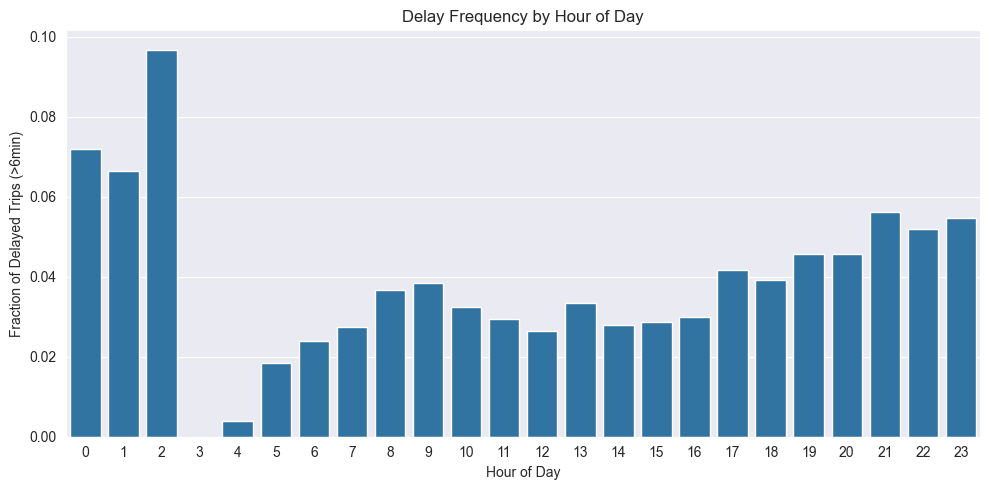

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Dask to pandas for plotting
delays_by_hour_pd = delays_by_hour.reset_index()
delays_by_hour_pd.columns = ["Hour", "Share Delayed"]

plt.figure(figsize=(10, 5))
sns.barplot(x="Hour", y="Share Delayed", data=delays_by_hour_pd)
plt.title("Delay Frequency by Hour of Day")
plt.ylabel("Fraction of Delayed Trips (>6min)")
plt.xlabel("Hour of Day")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


### Delays by Weekday

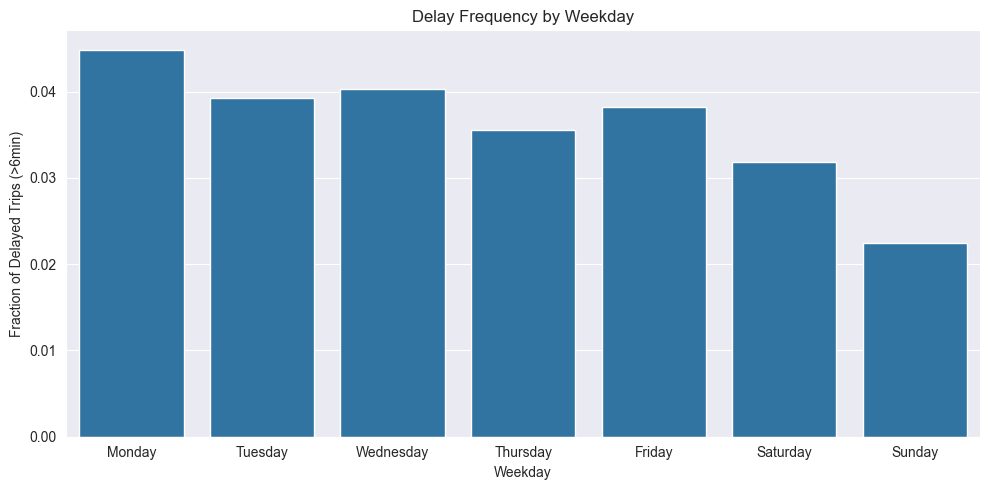

In [7]:
# Ensure weekday order
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
delays_by_day_pd = delays_by_day.reset_index()
delays_by_day_pd.columns = ["Weekday", "Share Delayed"]
delays_by_day_pd["Weekday"] = pd.Categorical(delays_by_day_pd["Weekday"], categories=weekday_order, ordered=True)
delays_by_day_pd = delays_by_day_pd.sort_values("Weekday")

plt.figure(figsize=(10, 5))
sns.barplot(x="Weekday", y="Share Delayed", data=delays_by_day_pd)
plt.title("Delay Frequency by Weekday")
plt.ylabel("Fraction of Delayed Trips (>6min)")
plt.xlabel("Weekday")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

### Top 10 most delayed stations

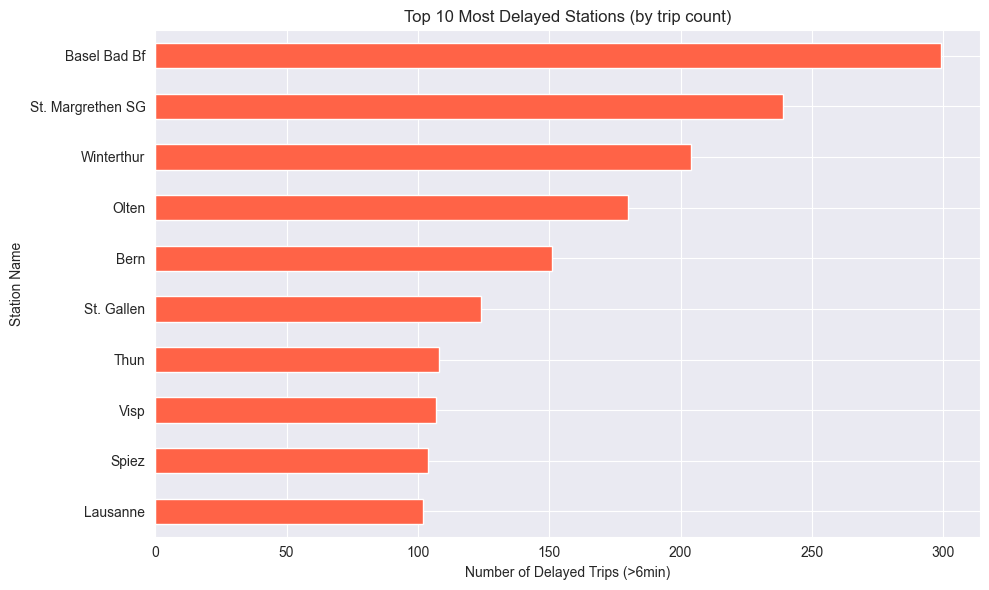

In [8]:
top_stations = top_delayed_stations.head(10)

plt.figure(figsize=(10, 6))
top_stations.sort_values().plot(kind='barh', color='tomato')
plt.title("Top 10 Most Delayed Stations (by trip count)")
plt.xlabel("Number of Delayed Trips (>6min)")
plt.ylabel("Station Name")
plt.tight_layout()
plt.show()


### Average delays per train type


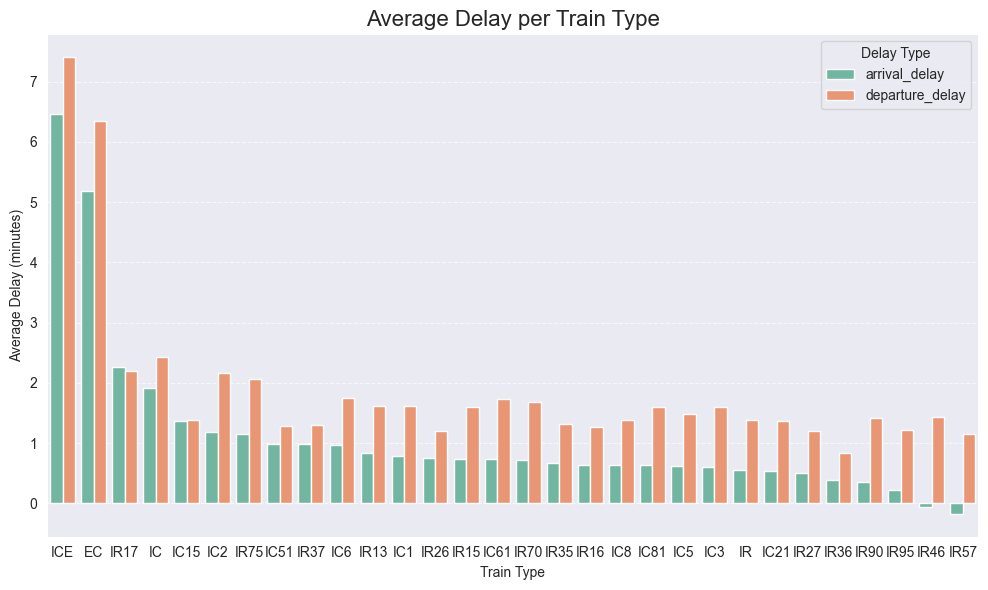

In [9]:
# Reset index to use 'LINIEN_TEXT' as a column
df_delay = avg_delay_all.reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_delay.melt(id_vars="LINIEN_TEXT",
                               value_vars=["arrival_delay", "departure_delay"],
                               var_name="Delay Type",
                               value_name="Minutes"),
            x="LINIEN_TEXT", y="Minutes", hue="Delay Type", palette="Set2")

plt.title("Average Delay per Train Type", fontsize=16)
plt.ylabel("Average Delay (minutes)")
plt.xlabel("Train Type")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Performance Measurements

To efficiently process the dataset (which includes tens of millions of records), we applied the following optimizations:

- Lazy loading and filtering with Dask
- Explicit `dtype` definitions and `assume_missing=True`
- Deferred computation using `.persist()` and `.compute()` only when needed

Measured runtimes:
- File extraction and loading: approximately X minutes
- Filtering and transformation: approximately Y minutes


In [10]:
print("------ Performance Measurements Summary ------")
print(f"CSV Files Read:         {csv_read_duration:.2f} seconds")
print(f"Filter + Persist:       {filter_duration:.2f} seconds")
print(f"Compute Avg Delays:     {avg_delay_duration:.2f} seconds")
print(f"GroupBy Delay Stats:    {delay_stats_duration:.2f} seconds")
print("----------------------------------------------")


------ Performance Measurements Summary ------
CSV Files Read:         0.06 seconds
Filter + Persist:       219.64 seconds
Compute Avg Delays:     0.90 seconds
GroupBy Delay Stats:    4.11 seconds
----------------------------------------------


# Conclusions

- Average delays are now computed across all trains, providing a more realistic assessment of service performance.
- Certain train lines (e.g., ICE, EC) show higher average delays than others (e.g., IR).
- Peak hours and weekdays show a higher proportion of delayed trips.
- Busy stations such as Zurich HB and Bern frequently appear in the top delay rankings.

## Reflection

Compared to PySpark, Dask offered:

- Simpler local setup without needing a distributed cluster
- Familiar syntax (Pandas-compatible)
- Easier debugging and control


## Dask-Specific Conclusions

### Performance & Scalability
- Dask handled 70M+ rows efficiently on a local machine, demonstrating strong capabilities for medium-sized data.
- The ability to scale computations from a single machine to a distributed cluster offers flexibility depending on dataset size and hardware constraints.
- Lazy evaluation enabled us to chain complex transformations without incurring immediate computational cost.

### Ease of Use
- The API closely mimics Pandas, significantly reducing the learning curve for data scientists familiar with the Pandas ecosystem.
- Debugging was easier than with PySpark, as Dask workflows are Python-native and don't require Spark context or cluster setup.

### Limitations
- Performance can drop if the number of partitions is not optimized, especially when working with smaller-than-ideal chunk sizes.
- Certain operations (e.g., complex groupby + aggregation + sort chains) can become memory intensive if not handled carefully.
- Visualization and interactive development (e.g., `.head()`, `.sample()`) are slower than in Pandas due to the lazy nature of Dask.

### Suitability for the Use Case
- Dask was a great fit for this project, allowing us to:
  - Handle multi-gigabyte monthly public transport data
  - Apply real-time filtering, transformations, and aggregations
  - Avoid cloud-based Spark setup or container orchestration overhead

Dask served as a powerful and pragmatic alternative to Spark for this mid-size analytics task on a local setup.
